<h1>Custom CNN for Image Classification using PyTorch</h1>

<h2>MNIST Digit Recognition</h2>

<p><b>Code written by Seetha Parameswaran</b></p>

<hr>

<h3>Overview</h3>
<p>This exercise demonstrates <b>Custom CNN implementation using PyTorch</b> for MNIST digit classification (0-9). PyTorch offers dynamic computation graphs and explicit control over training loops.</p>

<h4>PyTorch CNN Components:</h4>
<ul>
  <li><b>nn.Conv2d</b>: 2D convolutional layers</li>
  <li><b>nn.MaxPool2d</b>: Max pooling layers</li>
  <li><b>nn.Linear</b>: Fully connected (Dense) layers</li>
  <li><b>Manual training loop</b>: Explicit forward/backward passes</li>
  <li><b>nn.CrossEntropyLoss</b>: Combined softmax + loss</li>
</ul>

<hr>

<h3>Learning Outcomes</h3>
<ul>
  <li>✓ Build CNN using PyTorch nn.Module</li>
  <li>✓ Implement custom forward() method</li>
  <li>✓ Write manual training loops with backpropagation</li>
  <li>✓ Use DataLoader for batch processing</li>
  <li>✓ Evaluate with accuracy, precision, recall, F1-score</li>
</ul>

<hr>

<h3>Network Architecture</h3>
<pre>
Input (1×28×28)
   ↓
Conv2d (32 filters, 3×3) + ReLU
   ↓
MaxPool2d (2×2)
   ↓
Conv2d (64 filters, 3×3) + ReLU
   ↓
MaxPool2d (2×2)
   ↓
Flatten (view)
   ↓
Linear (128) + ReLU + Dropout(0.5)
   ↓
Linear (10)
</pre>

In [2]:
# Import Libraries
# pip install torch torchvision torchaudio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import random

In [3]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## PART 1: LOAD AND PREPROCESS MNIST DATASET

In [4]:
print("\n[1] Loading MNIST dataset...")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


[1] Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:04<00:00, 2.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 140kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.29MB/s]

Training samples: 60000
Test samples: 10000


## PART 2: BUILD CUSTOM CNN MODEL

In [5]:
print("\n[2] Building custom CNN architecture...")

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # After 2 conv+pool: 28->26->13->11->5
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # First conv block
        x = self.pool(F.relu(self.conv1(x)))
        
        # Second conv block
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten
        x = x.view(-1, 64 * 5 * 5)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create model instance
model = CustomCNN().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Print model architecture
print("\nModel Architecture:")
print(model)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


[2] Building custom CNN architecture...

Total parameters: 225,034

Model Architecture:
CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## PART 3: TRAIN MODEL

In [6]:
print("\n[3] Training model...")

n_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    # Calculate epoch metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase (using test set as validation)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{n_epochs}] - '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# Track initial and final loss
initial_loss = train_losses[0]
final_loss = train_losses[-1]

print(f"\nInitial training loss: {initial_loss:.4f}")
print(f"Final training loss:   {final_loss:.4f}")


[3] Training model...
Epoch [1/10] - Train Loss: 0.2668, Train Acc: 91.81% - Val Loss: 0.0570, Val Acc: 98.25%
Epoch [2/10] - Train Loss: 0.0839, Train Acc: 97.60% - Val Loss: 0.0388, Val Acc: 98.74%
Epoch [3/10] - Train Loss: 0.0622, Train Acc: 98.14% - Val Loss: 0.0288, Val Acc: 98.93%
Epoch [4/10] - Train Loss: 0.0506, Train Acc: 98.47% - Val Loss: 0.0291, Val Acc: 98.97%
Epoch [5/10] - Train Loss: 0.0445, Train Acc: 98.64% - Val Loss: 0.0297, Val Acc: 99.04%
Epoch [6/10] - Train Loss: 0.0385, Train Acc: 98.78% - Val Loss: 0.0280, Val Acc: 99.03%
Epoch [7/10] - Train Loss: 0.0315, Train Acc: 99.02% - Val Loss: 0.0279, Val Acc: 99.13%
Epoch [8/10] - Train Loss: 0.0289, Train Acc: 99.10% - Val Loss: 0.0253, Val Acc: 99.26%
Epoch [9/10] - Train Loss: 0.0279, Train Acc: 99.13% - Val Loss: 0.0226, Val Acc: 99.20%
Epoch [10/10] - Train Loss: 0.0228, Train Acc: 99.28% - Val Loss: 0.0232, Val Acc: 99.27%

Initial training loss: 0.2668
Final training loss:   0.0228


## PART 4: EVALUATE MODEL

In [7]:
print("\n[4] Evaluating model on test set...")

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.numpy())

# Convert to numpy arrays
Y_pred_classes = np.array(all_predictions)
Y_test_classes = np.array(all_targets)

# Calculate all metrics
accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
precision = precision_score(Y_test_classes, Y_pred_classes, average='weighted')
recall = recall_score(Y_test_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes, average='weighted')


print("MODEL PERFORMANCE METRICS")
print("="*70)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}") 


[4] Evaluating model on test set...
MODEL PERFORMANCE METRICS
Accuracy:  0.9927
Precision: 0.9927
Recall:    0.9927
F1-Score:  0.9927


## PART 5: VISUALIZATIONS


[5] Generating visualizations...


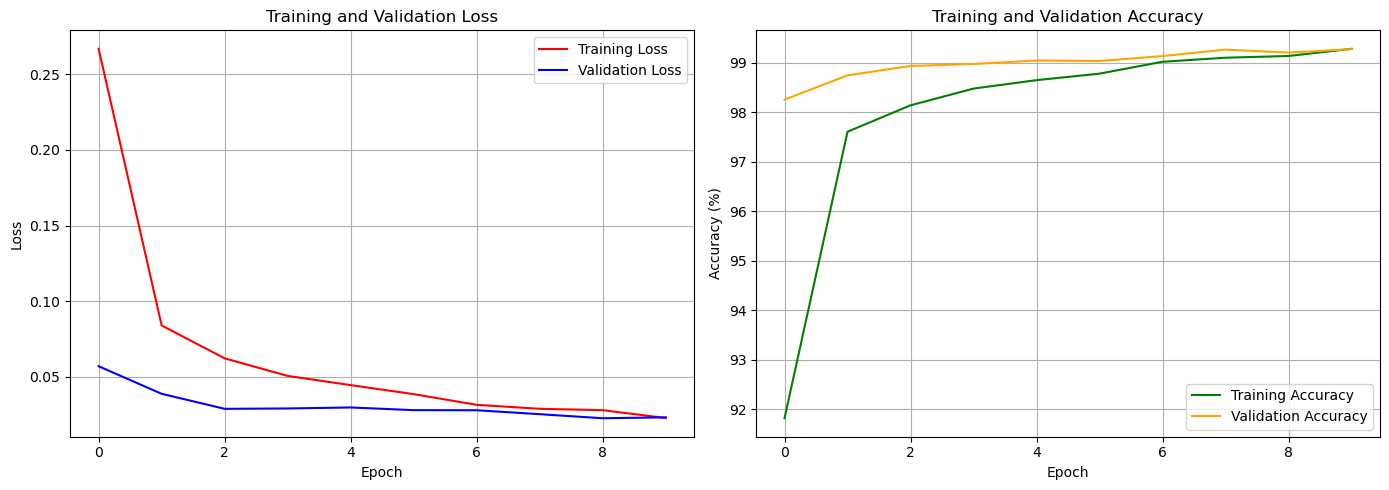

In [8]:
print("\n[5] Generating visualizations...")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', color='red')
axes[0].plot(val_losses, label='Validation Loss', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accuracies, label='Training Accuracy', color='green')
axes[1].plot(val_accuracies, label='Validation Accuracy', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

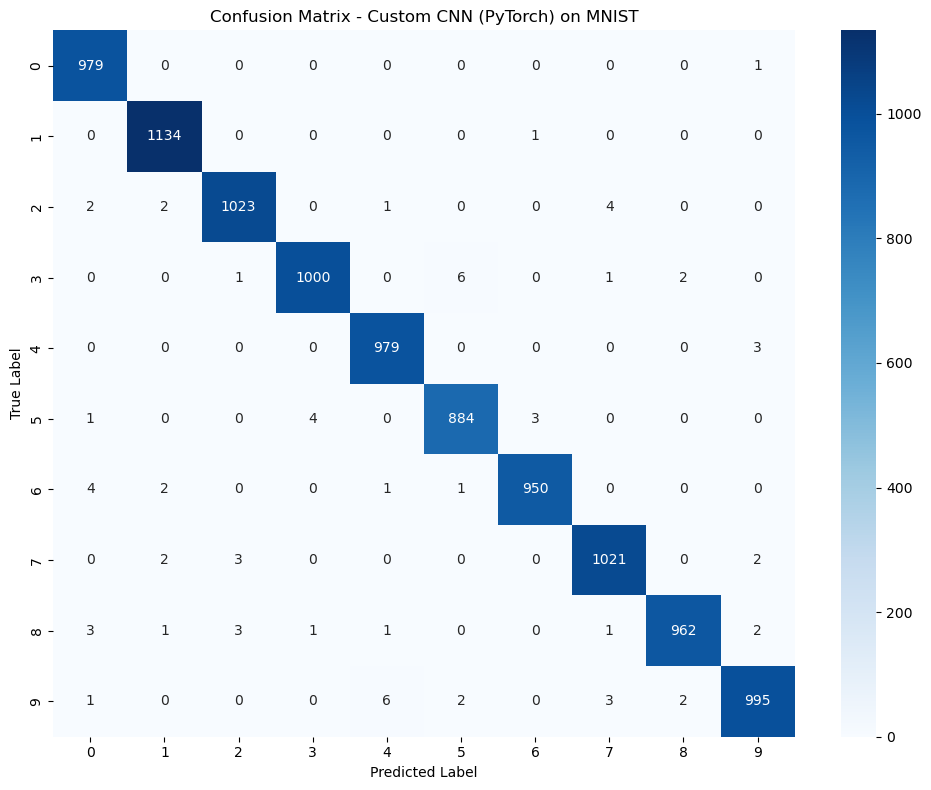

In [9]:
# Confusion Matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom CNN (PyTorch) on MNIST')
plt.tight_layout()

In [10]:
# Classification Report 
print("CLASSIFICATION REPORT")
print(classification_report(Y_test_classes, Y_pred_classes, 
                          target_names=[str(i) for i in range(10)]))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## PART 6: VISUALIZE LEARNED FILTERS


[6] Visualizing learned filters from first Conv layer...


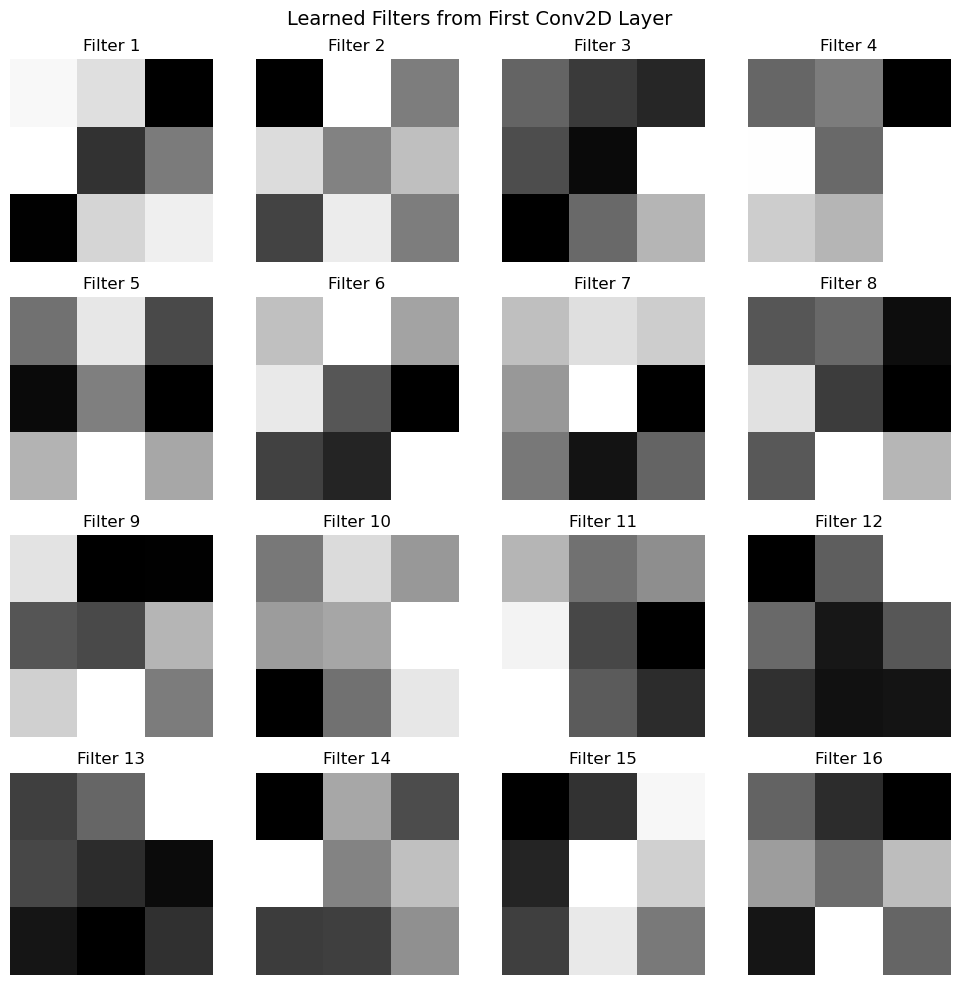

In [11]:
print("\n[6] Visualizing learned filters from first Conv layer...")

# Get weights from first convolutional layer
first_layer_weights = model.conv1.weight.data.cpu().numpy()
# Shape: (32, 1, 3, 3) - (output_channels, input_channels, height, width)

# Plot first 16 filters
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < 16:
        # Extract filter and squeeze channel dimension
        filter_img = first_layer_weights[i, 0, :, :]
        ax.imshow(filter_img, cmap='gray')
        ax.set_title(f'Filter {i+1}')
    ax.axis('off')

plt.suptitle('Learned Filters from First Conv2D Layer', fontsize=14)
plt.tight_layout()

## PART 7: SAMPLE PREDICTIONS


[7] Sample predictions...


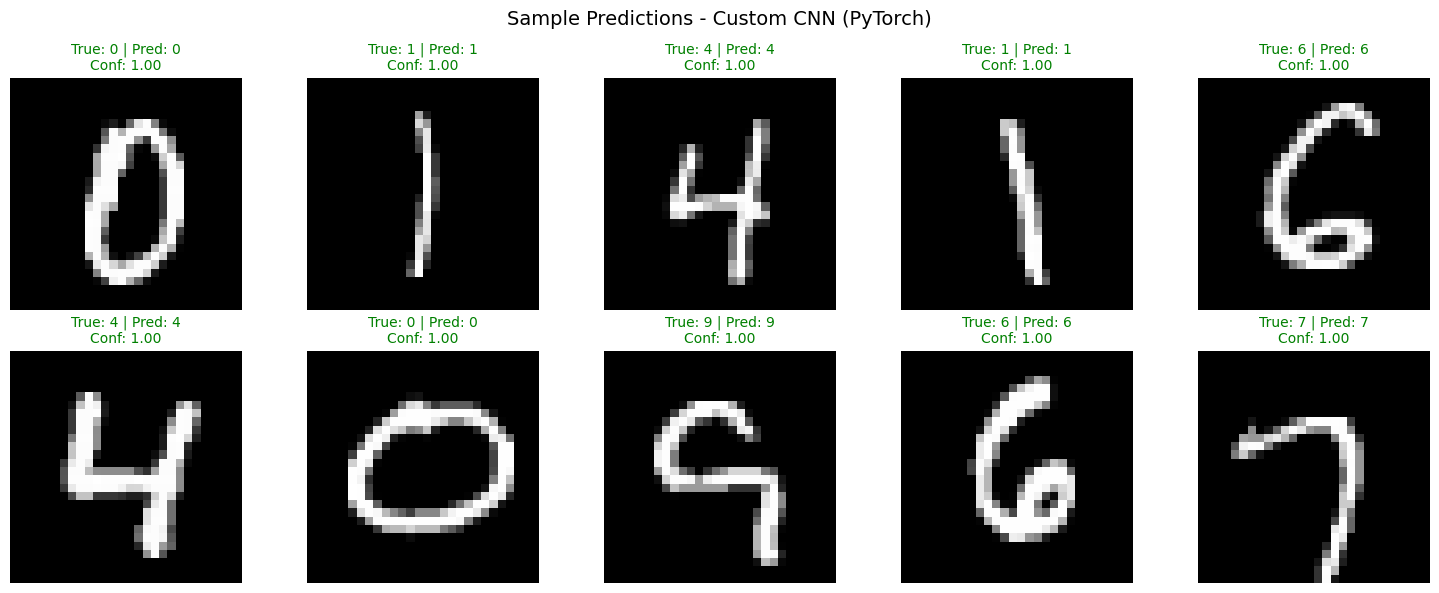

In [12]:
print("\n[7] Sample predictions...")

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, predictions = torch.max(outputs, 1)

# Select 10 random samples
n_samples = 10
indices = np.random.choice(len(images), n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in zip(indices, axes.flat):
    # Show original image
    img = images[idx].squeeze().cpu().numpy()
    ax.imshow(img, cmap='gray')
    
    true_label = labels[idx].item()
    pred_label = predictions[idx].item()
    
    # Get confidence (softmax probability)
    probs = F.softmax(outputs[idx], dim=0)
    confidence = probs[pred_label].item()
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label} | Pred: {pred_label}\nConf: {confidence:.2f}',
                color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('Sample Predictions - Custom CNN (PyTorch)', fontsize=14)
plt.tight_layout()

In [13]:
print("CUSTOM CNN TRAINING COMPLETE (PyTorch)") 
print(f"✓ Architecture: Conv2D → MaxPool → Conv2D → MaxPool → Flatten → Dense")
print(f"✓ Total Parameters: {total_params:,}")
print(f"✓ Test Accuracy: {accuracy:.4f}")
print(f"✓ Training Loss Decreased: {final_loss < initial_loss}")
print(f"✓ Framework: PyTorch {torch.__version__}")

CUSTOM CNN TRAINING COMPLETE (PyTorch)
✓ Architecture: Conv2D → MaxPool → Conv2D → MaxPool → Flatten → Dense
✓ Total Parameters: 225,034
✓ Test Accuracy: 0.9927
✓ Training Loss Decreased: True
✓ Framework: PyTorch 2.7.1+cu118


<hr style="border: 2px solid #4CAF50;"> 
<h3>Extensions and Student Exercises</h3>

<h4>1. Architecture Experiments</h4>
<ul>
  <li><b>Add layers</b>: Try 3-4 Conv2d layers</li>
  <li><b>Vary filters</b>: Use 16, 32, 64, 128 filters per layer</li>
  <li><b>Kernel sizes</b>: Experiment with 3×3, 5×5, 7×7</li>
  <li><b>Pooling variations</b>: Try AvgPool2d vs MaxPool2d</li>
</ul>

<h4>2. PyTorch-Specific Features</h4>
<ul>
  <li><b>Learning rate scheduling</b>: Use torch.optim.lr_scheduler</li>
  <li><b>Batch normalization</b>: Add nn.BatchNorm2d layers</li>
  <li><b>Weight initialization</b>: Try kaiming_normal_, xavier_uniform_</li>
  <li><b>GPU acceleration</b>: Profile training speed on CUDA</li>
</ul>

<h4>3. Training Enhancements</h4>
<ul>
  <li><b>Optimizers</b>: Compare Adam, SGD, RMSprop, AdamW</li>
  <li><b>Early stopping</b>: Implement validation-based stopping</li>
  <li><b>Gradient clipping</b>: Use torch.nn.utils.clip_grad_norm_</li>
  <li><b>Mixed precision</b>: Try torch.cuda.amp for faster training</li>
</ul>

<h4>4. Data Augmentation</h4>
<ul>
  <li>Use <b>torchvision.transforms</b>: RandomRotation, RandomCrop</li>
  <li>Implement <b>custom transforms</b> for noise injection</li>
  <li>Try <b>Cutout/Mixup</b> augmentation techniques</li>
</ul>

<h4>5. Alternative Datasets</h4>
<ul>
  <li>Fashion-MNIST (10 clothing classes)</li>
  <li>CIFAR-10 (32×32 color images)</li>
  <li>SVHN (Street View House Numbers)</li>
</ul>

<h4>Challenge Problems</h4>
<ol>
  <li>Achieve <b>99%+ accuracy</b> on MNIST test set</li>
  <li>Build model with <b>&lt;50K parameters</b> maintaining 98%+ accuracy</li>
  <li>Implement <b>model checkpointing</b> to save best weights</li>
  <li>Add <b>TensorBoard logging</b> for visualization</li>
</ol>

<hr>
<h4><center>Happy coding</center></h4>